# Kinds of kindess: regression analysis

In [13]:
import sys
sys.path.append('/Users/federicobassi/Desktop/TI.nosync/MPhil_Thesis/python/utils')
from utils.data_generation import *
from utils.data_plotting import *
from utils.test_rev_pref import *
from utils.maximize_utility_bc import *
from utils.budget_placement import *
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
import pickle
np.random.seed(123)

## Setup

In [14]:
path = "/Users/federicobassi/Desktop/TI.nosync/MPhil_Thesis"
img_path = path+"/plots"
out = path + "/simulated_data"

In [15]:
andreoni_miller_budgets = [(120, 40), (40, 120), (120, 60), (60, 120), (150, 75),
                               (75, 150), (60, 60), (100, 100), (80, 80), (160, 40), (40, 160)]

with open(out+"/budget_constraints_alg1.pkl", "rb") as f:
    budget_constraints_alg1 = pickle.load(f)

with open(out+"/budget_constraints_alg2.pkl", "rb") as f:
    budget_constraints_alg2 = pickle.load(f)

## Regression analysis with simulated data

In [16]:
# ======================================================================
# 0.  SETTINGS
# ======================================================================
# Folder where the two Excel files will be written
OUT_DIR = ("/Users/federicobassi/Desktop/TI.nosync/MPhil_Thesis/simulated_data")
# Number of *subjects* (not choices) in each experimental arm
N_PER_GROUP = 300
# Seed for NumPy’s random-number generator — makes the whole run reproducible
SEED = 2025
rng = np.random.default_rng(SEED) 

# ======================================================================
# 1.  DRAW ALL PARAMETERS ONCE
# ======================================================================
# We draw 3 × N_PER_GROUP independent samples of α and ρ:
#   – treatment-high (selfish)   : α ~ scaled Beta(4,2)
#   – treatment-low  (altruist)  : α ~ scaled Beta(2,4)
#   – control (uniform)          : α ~ U[0.5, 1]
alpha_high_vals = 0.5 + 0.5 * rng.beta(4, 2,  N_PER_GROUP)  # selfish
alpha_low_vals  = 0.5 + 0.5 * rng.beta(2, 4,  N_PER_GROUP)  # altruistic
alpha_ctrl_vals =        rng.uniform(0.5, 1.0, N_PER_GROUP) # control

# ρ is always uniform
rho_high_vals   = rng.uniform(-0.5, 0.95, N_PER_GROUP)
rho_low_vals    = rng.uniform(-0.5, 0.95, N_PER_GROUP)
rho_ctrl_vals   = rng.uniform(-0.5, 0.95, N_PER_GROUP)


# ======================================================================
# 2.  “STREAM” CLASS  — feeds the parameters to simulate_dataset()
# ======================================================================
class Stream:
    """
    A tiny iterator-like wrapper that hands out one element of a
    pre-computed NumPy array each time .draw() is called.

    Why bother?
    -----------
    • simulate_dataset() wants *callables* (no arguments, just () ) that
      return a fresh draw every time it needs one.
    • By pre-drawing the entire parameter list, we can replay the *exact
      same sequence* for the second budget set merely by resetting the
      internal pointer (self.i) back to zero.
    • This is safer than rewinding the RNG state, because no matter what
      other random draws take place inside simulate_dataset(), the stream
      returns the predetermined values in the predetermined order.
    """

    def __init__(self, arr: np.ndarray):
        self.arr = arr          # the fixed list of values
        self.i   = 0            # pointer to "next unread element"

    def draw(self) -> float:
        """Return the next value and advance the pointer."""
        val = self.arr[self.i]  # pull element i
        self.i += 1             # move pointer to i+1
        return float(val)       # cast to plain Python float for safety

    def reset(self):
        """Rewind the pointer to the beginning so we can replay the stream."""
        self.i = 0


# Instantiate a separate Stream for every (group × parameter) combination
stream_high_alpha = Stream(alpha_high_vals)
stream_low_alpha  = Stream(alpha_low_vals)
stream_ctrl_alpha = Stream(alpha_ctrl_vals)

stream_high_rho   = Stream(rho_high_vals)
stream_low_rho    = Stream(rho_low_vals)
stream_ctrl_rho   = Stream(rho_ctrl_vals)

# Each param_dist_* dict now supplies *functions* that call .draw()
param_dist_high = {
    "alpha_ces": stream_high_alpha.draw,
    "rho_ces"  : stream_high_rho.draw,
}
param_dist_low  = {
    "alpha_ces": stream_low_alpha.draw,
    "rho_ces"  : stream_low_rho.draw,
}
param_dist_ctrl = {
    "alpha_ces": stream_ctrl_alpha.draw,
    "rho_ces"  : stream_ctrl_rho.draw,
}


# ======================================================================
# 3.  build_panel()  — one run of simulate_dataset for a given budget set
# ======================================================================

def build_panel(budgets, tag):
    """
    budgets : list of (max_self, max_other) tuples defining the menu.
    tag     : string appended to the Excel filename (e.g. 'andreoni_miller').

    The routine:
      1. Calls simulate_dataset() three times (one per treatment arm)
         using the *same* parameter streams defined above.
      2. Renumbers subject IDs so they remain unique across arms.
      3. Adds a 'treatment' flag: 0=control · 1=high-α · 2=low-α
      4. Computes convenience vars g (share given) and price.
      5. Saves the concatenated dataframe to OUT_DIR/regression_<tag>.xlsx
    """

    # ---------- 3.1  Generate data for each arm ----------
    _, df_high = simulate_dataset(
        budgets=budgets,
        utility_func=ces,
        param_distributions=param_dist_high,
        n_samples=N_PER_GROUP,
        noise_sd=[5],
        maximiser="exact",
    )

    _, df_low = simulate_dataset(
        budgets=budgets, utility_func=ces,
        param_distributions=param_dist_low,
        n_samples=N_PER_GROUP, noise_sd=[5], maximiser="exact"
    )

    _, df_ctrl = simulate_dataset(
        budgets=budgets, utility_func=ces,
        param_distributions=param_dist_ctrl,
        n_samples=N_PER_GROUP, noise_sd=[0], maximiser="exact"
    )

    # ---------- 3.2  Make subject IDs unique ----------
    # Each simulate_dataset() starts counting IDs at 1, so we shift
    # the low-α IDs up by max(high) and the control IDs up by max(low).
    df_low ["id"] += df_high["id"].max() + 1
    df_ctrl["id"] += df_low ["id"].max()  + 1

    # ---------- 3.3  Treatment labels ----------
    df_high["treatment"] = 1   # selfish (high α)
    df_low ["treatment"] = 2   # altruistic (low α)
    df_ctrl["treatment"] = 0   # control (uniform α)

    # Concatenate the three arms row-wise
    df = pd.concat([df_high, df_low, df_ctrl], ignore_index=True)

    # ---------- 3.4  Post-processing ----------
    # Share given to the recipient
    df["g"] = df["noisy_y"] / (df["noisy_x"] + df["noisy_y"])

    # Relative price of giving
    df["price"] = df["max_self"] / df["max_other"]

    # ---------- 3.5  Save to Excel ----------
    fname = f"{OUT_DIR}/regression_{tag}.xlsx"
    df.to_excel(fname, index=False)
    print(f"✔  Saved {fname}")

    return df



# ======================================================================
# 4-A.  FIRST PASS  — Andreoni & Miller budgets
# ======================================================================
df_am = build_panel(andreoni_miller_budgets, tag="andreoni_miller")



# ======================================================================
# 4-B.  RESET STREAMS & SECOND PASS  — Algorithm-2 budgets
# ======================================================================
# Before re-using the same Streams we must rewind them,
# otherwise .draw() would raise StopIteration.
"""
for s in (
    stream_high_alpha, stream_low_alpha, stream_ctrl_alpha,
    stream_high_rho,   stream_low_rho,   stream_ctrl_rho
):
    s.reset()

df_alg2 = build_panel(budget_constraints_alg2, tag="alg2")

for s in (
    stream_high_alpha, stream_low_alpha, stream_ctrl_alpha,
    stream_high_rho,   stream_low_rho,   stream_ctrl_rho
):
    s.reset()

df_alg2_more_prices = build_panel(budget_constraints_alg2_more_prices, tag="alg2-more_prices")
"""
for s in (
    stream_high_alpha, stream_low_alpha, stream_ctrl_alpha,
    stream_high_rho,   stream_low_rho,   stream_ctrl_rho
):
    s.reset()

df_alg2_more_prices = build_panel(budget_constraints_alg2, tag="alg2")

✔  Saved /Users/federicobassi/Desktop/TI.nosync/MPhil_Thesis/simulated_data/regression_andreoni_miller.xlsx
✔  Saved /Users/federicobassi/Desktop/TI.nosync/MPhil_Thesis/simulated_data/regression_alg2.xlsx


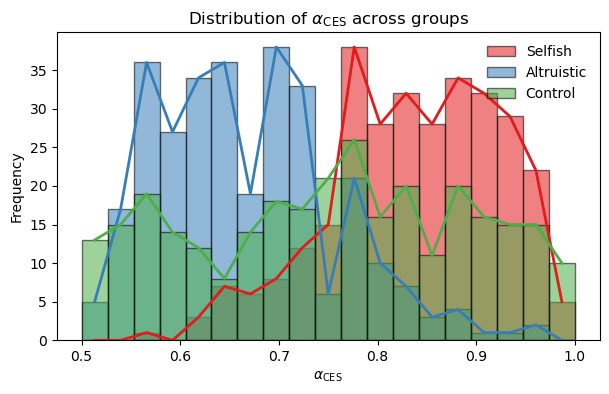

In [17]:
## ------------------------------------------------------------------
# Helper: one α per subject id
# ------------------------------------------------------------------
def get_alpha_series(df):
    if "id" not in df.columns:
        raise KeyError("'id' column missing")
    dfu = df.drop_duplicates("id")
    if "alpha_ces" in dfu:            return dfu["alpha_ces"]
    if "utility_label" in dfu:        return dfu["utility_label"].apply(lambda d: d["alpha_ces"])
    raise KeyError("α not found")

# ------------------------------------------------------------------
# Main plotting function
# ------------------------------------------------------------------
def plot_alpha_distributions(group_dfs,
                             add_smooth=False,
                             img_path=None,
                             fname="alpha_dists.png"):

    palette  = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00"]
    colours  = {lab: palette[i] for i, (lab, _) in enumerate(group_dfs)}

    plt.style.use("default")
    fig, ax = plt.subplots(figsize=(7, 4))

    bins        = np.linspace(0.5, 1.0, 20)
    hist_kwargs = dict(bins=bins,
                       edgecolor="black",
                       alpha=0.55,
                       density=False)

    # ---------- draw histograms (and optional connecting line) ----------
    for label, df in group_dfs:
        alpha = get_alpha_series(df)

        # — histogram in counts —
        counts, edges, _ = ax.hist(alpha,
                                   label=label,
                                   color=colours[label],
                                   **hist_kwargs)

        # — optional line through bar tops —
        if add_smooth:
            centres = (edges[:-1] + edges[1:]) / 2
            ax.plot(centres, counts,
                    color=colours[label],
                    linewidth=2)

    # ---------- cosmetics ----------
    ax.set_xlabel(r"$\alpha_{\mathrm{CES}}$")
    ax.set_ylabel("Frequency")
    ax.set_title(r"Distribution of $\alpha_{\mathrm{CES}}$ across groups")
    ax.legend(frameon=False)

    if img_path:
        fig.savefig(f"{img_path}/{fname}", bbox_inches="tight", dpi=300)
    plt.show()

plot_alpha_distributions(
    [("Selfish", df_am[df_am.treatment==1]),
     ("Altruistic", df_am[df_am.treatment==2]),
     ("Control", df_am[df_am.treatment==0])],
    add_smooth=True,
    img_path=img_path,
    fname="alpha_distributions.png",
)